<a href="https://colab.research.google.com/github/KumudaBG/Insincere-Question-classification-On-Quora/blob/main/LearningPhase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of insincere Quora Questions

This case study aims at classifying the insincere questions that appear on quora time to time. Quora and all other social media platform deal with the problem of insincere question, posts and various other content. In order to fight this problem, we will be utilizing the data provided by Quora and perform various Feature engineering tasks along with Machine Learning algorithm in order o classify the Sincere vs Insincere questions.

**Data Source**
The data source we are using is from Kaggle.com.

https://www.kaggle.com/c/quora-insincere-questions-classification/notebooks



In [ ]:
# importing python libraries
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as pt
import seaborn as sns
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
from joblib import load
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
import pandas as pd
from sklearn.model_selection import train_test_split
import concurrent.futures
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
import itertools
from joblib import dump
from sklearn import linear_model

In [ ]:
from google.colab import files
uploaded = files.upload()

# Exploratory Data Analysis

> Indented block


We are using the dataset provided in the Quora Insincere Questions Classification Competition, [Kaggle](https://www.kaggle.com/c/quora-insincere-questions-classification/data?select=train.csv)






In [ ]:
df=pd.read_csv('train.csv')

##Data fields
*   qid - unique question identifier 
*   question_text - Quora question text
*   target - a question classified as "insincere" has a value of 1, else 0


In [ ]:
df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   qid            1306122 non-null  object
 1   question_text  1306122 non-null  object
 2   target         1306122 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 29.9+ MB


In [ ]:
#Check for NULL values
df.isnull().values.any()

False

In [ ]:
print("Number of question texts in training data:", df.shape[0])

Number of question texts in training data: 1306122


In [ ]:
#number of questions in the train dataset in both the class
targets = df['target'].value_counts()
print('Sincere Questions : ',targets[0])
print('Insincere Questions : ',targets[1])

Sincere Questions :  1225312
Insincere Questions :  80810


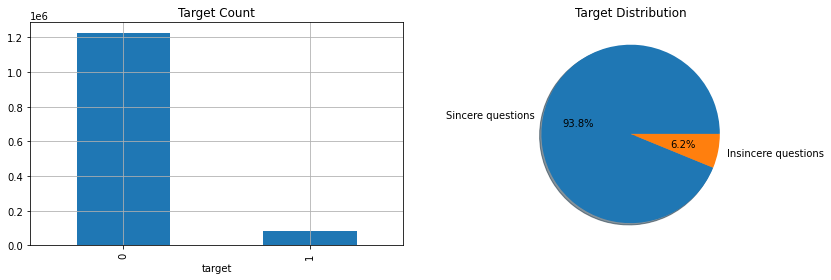

In [ ]:
# Bar chart
pt.subplot(1, 2, 1)
df.groupby('target')['qid'].count().plot.bar()
pt.grid(True)
pt.title('Target Count')
pt.subplots_adjust(right=1.9)

# Pie Chart
pt.subplot(1, 2, 2)
values = [df[df['target']==0].shape[0], df[df['target']==1].shape[0]]
labels = ['Sincere questions', 'Insincere questions']

pt.pie(values, labels=labels, autopct='%1.1f%%', shadow=True)
pt.title('Target Distribution')
pt.tight_layout()
pt.subplots_adjust(right=1.9)
pt.show()

In [ ]:
from wordcloud import WordCloud, STOPWORDS
def word_cloud(text, title):
    text_corpus = []
    for line in text.values:
        text_corpus.append(str(line).lower().split())

    num = 0
    comment_words = ' '
    while num < len(text_corpus):
        for word in text_corpus[num]:
            comment_words += word + ' '
            num += 1

    wordcloud = WordCloud(width=1200, height=800, stopwords=STOPWORDS, min_font_size=20).generate(comment_words)
    pt.figure(figsize=(10, 10))
    pt.title(title)
    pt.imshow(wordcloud, interpolation='bilinear')
    pt.axis("off")
    pt.show()

In [ ]:
insincere_train = df[df["target"] == 1]
sincere_train = df[df["target"] == 0]

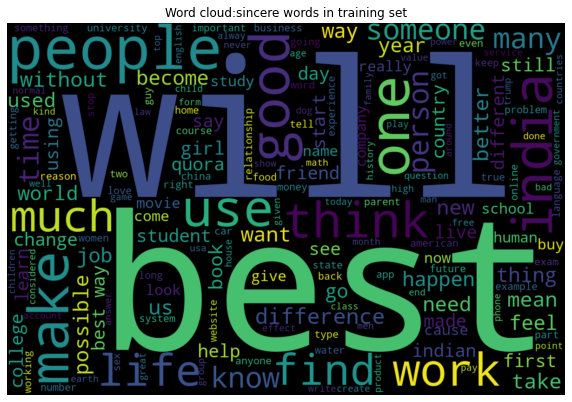

In [ ]:
word_cloud(sincere_train['question_text'], "Word cloud:sincere words in training set")

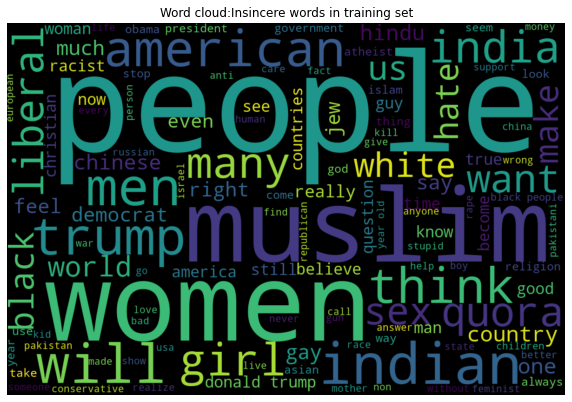

In [ ]:
word_cloud(insincere_train['question_text'],"Word cloud:Insincere words in training set")

In [ ]:
## Create new variable measuring the length of each question
df['question_length'] = df['question_text'].apply(lambda x: len(x.split()))

##Number of words in the text ##
df["num_word"] = df["question_text"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
df["num_unique_word"] = df["question_text"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text ##
df["num_char"] = df["question_text"].apply(lambda x: len(str(x)))

## Number of stopwords in the text ##
eng_stopwords = set(stopwords.words("english"))
df["num_stopword"] = df["question_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

## Number of title case words in the text ##
df["num_word_upper"] = df["question_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the text ##
df["num_word_title"] = df["question_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the text ##
df["mean_word_len"] = df["question_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# Number of special characters
df['num_special_char'] = df['question_text'].str.findall(r'[^a-zA-Z0-9 ]').str.len()
df.head()

,qid,question_text,target,question_length,num_word,num_unique_word,num_char,num_stopword,num_word_upper,num_word_title,mean_word_len,num_special_char
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,13,13,13,72,7,0,2,4.615385,1
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,16,16,15,81,9,0,1,4.125000,2
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,10,10,8,67,3,0,2,5.800000,2
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,9,9,9,57,3,0,4,5.444444,1
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,15,15,15,77,8,2,3,4.200000,1


In [ ]:
print("Minimum length of a question:", min(df['num_word']))
print("Maximum length of a question:", max(df['num_word']))

Minimum length of a question: 1
Maximum length of a question: 134


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

[Text(0.5, 0, 'Number of Words'),
 Text(0.5, 1.0, 'Distribution of Question Length by Target Group: Blue=Sincere | Orange=Insincere')]

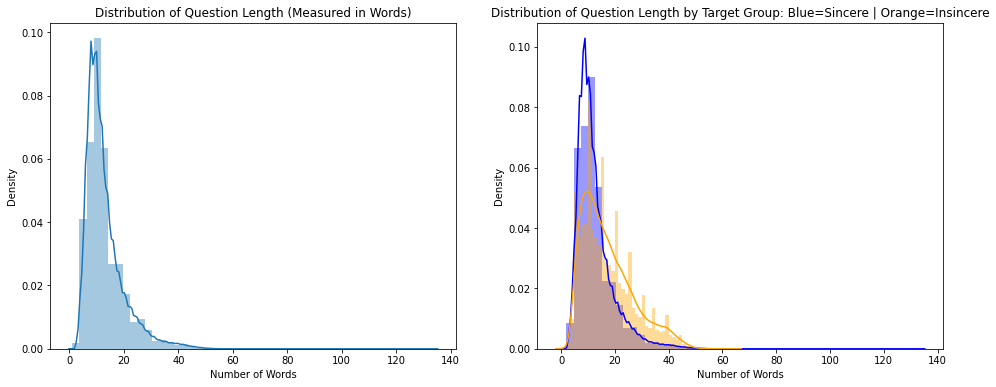

In [ ]:
import matplotlib.pyplot as pt
# Plot distribution of question lengths
fig, axes = pt.subplots(nrows=1, ncols=2)
fig.set_size_inches(16, 6)
sns.distplot(df['question_length'], ax=axes[0])
axes[0].set(xlabel='Number of Words', title='Distribution of Question Length (Measured in Words)')
sns.distplot(df['question_length'][df['target']==0], ax=axes[1],color='blue')
sns.distplot(df['question_length'][df['target']==1], ax=axes[1],color='orange')
axes[1].set(xlabel='Number of Words', title='Distribution of Question Length by Target Group: Blue=Sincere | Orange=Insincere')

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def display_boxplot(_x, _y, _data, _title):
    sns.boxplot(x=_x, y=_y, data=_data)
    pt.grid(True)
    pt.title(_title)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

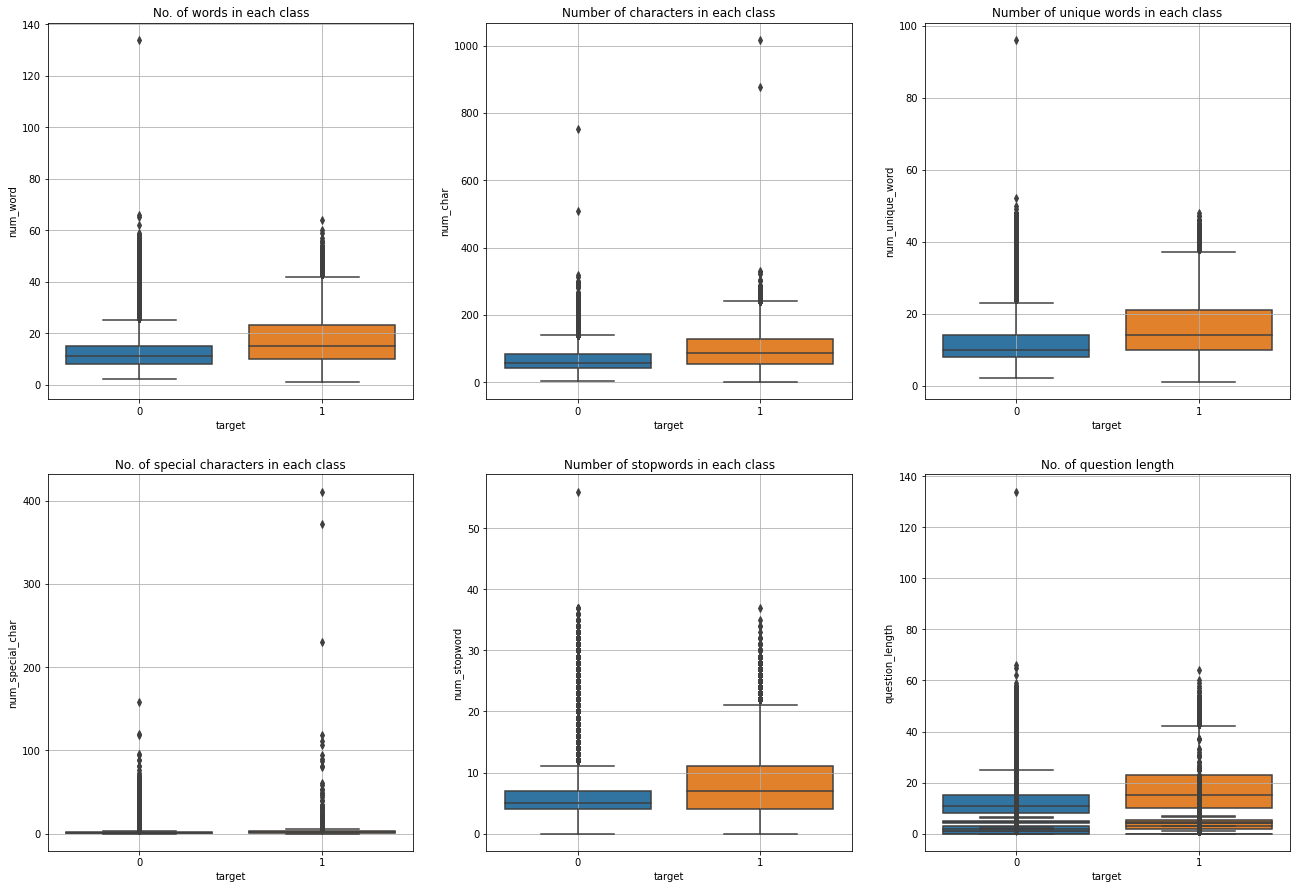

In [ ]:
# Boxplot: Number of words
pt.subplot(2, 3, 1)
display_boxplot('target', 'num_word', df, 'No. of words in each class')

# Boxplot: Number of chars
pt.subplot(2, 3, 2)
display_boxplot('target', 'num_char', df, 'Number of characters in each class')

# Boxplot: Number of unique words
pt.subplot(2, 3, 3)
display_boxplot('target', 'num_unique_word', df, 'Number of unique words in each class')

# Boxplot: Number of special characters
pt.subplot(2, 3, 4)
display_boxplot('target', 'num_special_char', df, 'No. of special characters in each class')

# Boxplot: Number of stopwords
pt.subplot(2, 3, 5)
display_boxplot('target', 'num_stopword', df, 'Number of stopwords in each class')

# Boxplot: Number of capital letters
pt.subplot(2, 3, 6)
display_boxplot('target', 'num_word_upper', df, 'No. of capital letters in each class')

# Boxplot: Number of title words
pt.subplot(2, 3, 6)
display_boxplot('target', 'num_word_title', df, 'No. of title words')

# Boxplot: Mean of word length
pt.subplot(2, 3, 6)
display_boxplot('target', 'mean_word_len', df, 'Mean of word length')

# Boxplot: Number of question length
pt.subplot(2, 3, 6)
display_boxplot('target', 'question_length', df, 'No. of question length')


pt.subplots_adjust(right=3.0)
pt.subplots_adjust(top=3.0)
pt.show()

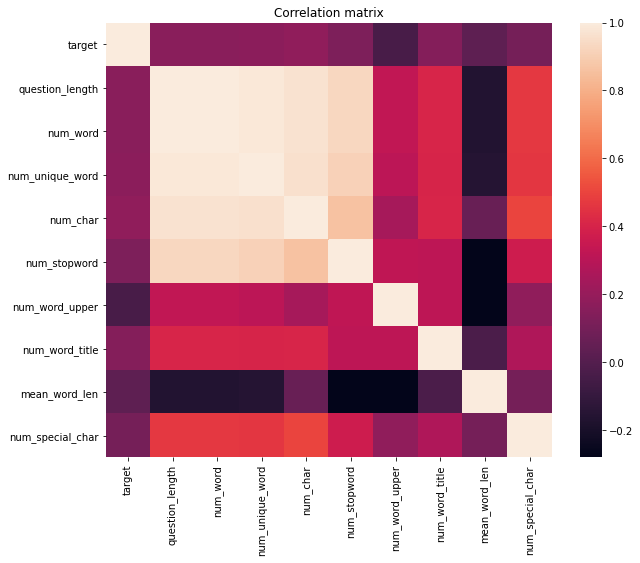

In [ ]:
# Correlation matrix
f, ax = pt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, ax=ax)
pt.title("Correlation matrix")
pt.show()

In [ ]:
def get_all_symbols(data):
  """
  Returns SET: special symbols in corpus
  """
  
  symbols = []
  for text in data:
    s = re.findall(r'\W+', str(text))
    symbols.extend(s), 
  
  return set(symbols)

In [ ]:
# Print the symbols present in each question text
extracted_symbols = get_all_symbols(df['question_text'].values)
print(extracted_symbols)

{'=? ', ' = {"', '; - ', ' √ {', '…") ', ':::::::', '+.....\\', '∆', '… "?', ')', "?' ", '!}\\', 'ా', '…?)?', ' (//', ']; ', ' ~?', ':\\?', '’/', '/ {(', ') =(-', " '?", '}\\ ', ' " . ', ') ^ (-', '÷(', '," ', '@ ', ' "&"?', '″, ', '=() /', '$ ', '} +\\', ' + ...... [/', '|-|-', "ை ' ", '}}\\, ', ' ->', ' }{ \\', '? :(:', ']", ', '][/', ' (\\', '} )[/', '/, ', '..), ', '़', '}+\\', '¯¯¯¯¯¯) ', '*) ', '? †', '×…×', ' {{ {(', "', ' ", '! =', ' √¡ +√-¡?', '] / (', '/√ ', 'ొ ', ' ([', '{-', '}<\\', '⬇️', ' = -', '"/"…', '்)- ', '়', '#? ', '}.', ' € / ', ', −', '/", ', '!!”, ', ' “@“ ', ' >>', ' ؟؟ ', 'ै', ' {\\', '」 ', "'? (+", '---', ' ∑ ', ': |?', '? ?', ' .. ', '} [/', ", '", ': …"? ', '™. ', ', +', ' " [', '"), ', ')) = (', '\'?" ', '™?', '➡+∞) ', '}-(', '/ো ', ' ," ', ']/', "？' ", ' (?) , ', '..)? ', '###', ' "/', ': [', ' ++*', ' |< ', '°) +', "?' (", ')|[/', '%), ', '} + ..... + \\', ' =\\', '∛', ', - ', ' : ', '+…+ (', '#". ', "%' ", '\' ("', '))/', ' [] =', '? ', "' (", '." - ', 

In [ ]:
# Questions with most number of non-alphanumeric characters.
# Sincere questions are printed in black color.
# Insincere questions are printed in red color.

qids = df.sort_values('num_special_char', ascending=False)['qid'].head(20).values
for id in qids:
  row = df[df['qid'].values == id]
  if row['target'].values[0] == 1: 
    color = '\033[31m'
  else:
    color = '\033[0m'
  print(color, row['question_text'].values[0], '\n')

 What is [math]\frac{\int_{1x^5}^{3x^{-5}} \tan(\tan({\boxed{\int_{1x^0}^{1x^2} \sum_{\varpi=1}^{\infty} \int_{2x^{-3}}^{2x^2} \sum_{\alpha=7}^{\infty} \underbrace{\sqrt[2]{1x^5}}_{\text{Gauss's Law of Theoretical Probability.}} d\tau dx}}^{1x^0})) d\mu}{\int_{2x^{-3}}^{1x^5} \cos(\int_{2x^2}^{1x^{-3}} \frac{\sqrt[2]{\overbrace{\underbrace{\frac{3x^3+3x^5}{\sqrt[3]{2x^{-3}}}}_{\text{Gauss's Law of Theoretical Probability.}} \times \overbrace{\tan(2x^0)}^{\text{Gauss's Law of Theoretical Probability.}}-\sum_{4=7}^{\infty} \boxed{3x^{-5}}}^{\text{Inverse Function.}}}}{{\boxed{\int_{2x^2}^{2x^4} 3x^1 d9} \div \sum_{6=6}^{\infty} \sqrt[3]{2x^2}+\sqrt[4]{\sin(2x^0+3x^0)}}^{2x^{-4}}+\boxed{\frac{\vec{\boxed{\sum_{\gamma=10}^{\infty} 1x^{-5}}}}{\frac{\sum_{\iota=2}^{\infty} 1x^{-5}-\frac{3x^{-1}}{1x^{-4}}}{\sin(\tan(3x^{-2}))}}}} \times \boxed{\sqrt[2]{{{{\sqrt[5]{2x^5}}^{2x^{-1}}}^{2x^{-1}} \div \sum_{\chi=6}^{\infty} \int_{1x^4}^{2x^{-4}} 3x^2 d\vartheta+{2x^{-3}}^{2x^{-5}}}^{3x^{-4}}}} d\m

In [ ]:
#Get all unigrams from the question text
def get_unigrams(data):
  unigrams = []
  for sent in data:
    unigrams.extend([w for w in sent.lower().split() if w not in STOPWORDS])
  return unigrams

#Get all bigrams from the question text
def get_bigrams(data):
  bigrams = []
  for sent in data:
    sent = [w for w in sent.lower().split() if w not in STOPWORDS]
    bi = [b for b in nltk.bigrams(sent)]
    bi = [' '.join(w) for w in bi]
    bigrams.extend(bi)
  return bigrams

#Get all trigrams from the question text  
def get_trigrams(data):
  trigrams = []
  for sent in data:
    sent = [w for w in sent.lower().split() if w not in STOPWORDS]
    ti = [t for t in nltk.trigrams(sent)]
    ti = [' '.join(w) for w in ti]
    trigrams.extend(ti)
  return trigrams

In [ ]:
# Unigrams
unigrams_sincere  = get_unigrams(df[df['target']==0]['question_text'])
unigrams_insincere = get_unigrams(df[df['target']==1]['question_text'])

# Bigrams
bigrams_sincere = get_bigrams(df[df['target']==0]['question_text'])
bigrams_insincere = get_bigrams(df[df['target']==1]['question_text'])

# Trigrams
trigrams_sincere = get_trigrams(df[df['target']==0]['question_text'])
trigrams_insincere = get_trigrams(df[df['target']==1]['question_text'])

In [ ]:
from collections import Counter

def plot_word_freq(data, title, bar_color): 
  top_words = Counter(data).most_common(25) #top 25 words
  df_top = pd.DataFrame(top_words, columns=['word', 'count']).sort_values('count') # storing in df
  pt.barh(df_top['word'].values, df_top['count'].values, orientation='horizontal', color=bar_color) # plot
  pt.title(f'Top words in {title}')

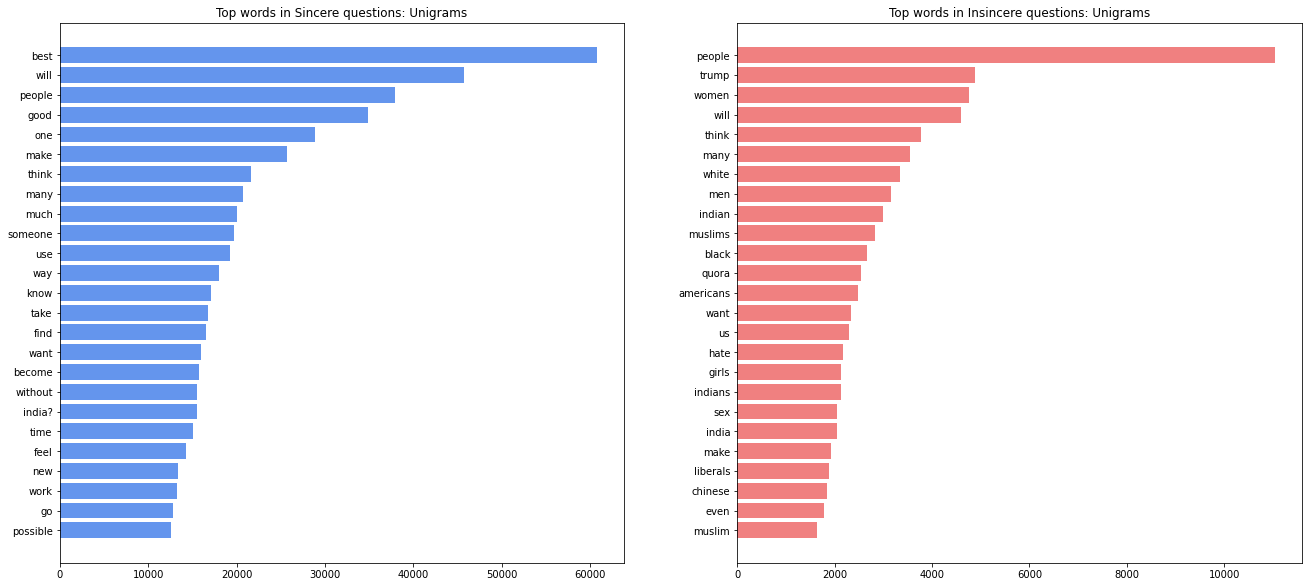

In [ ]:
# Unigrams Sincere words
pt.subplot(1, 2, 1)
plot_word_freq(unigrams_sincere, 'Sincere questions: Unigrams', 'cornflowerblue')

# Unigrams Insincere words
pt.subplot(1, 2, 2)
plot_word_freq(unigrams_insincere, 'Insincere questions: Unigrams', 'lightcoral')
pt.subplots_adjust(right=3.0)
pt.subplots_adjust(top=2.0)
pt.show()

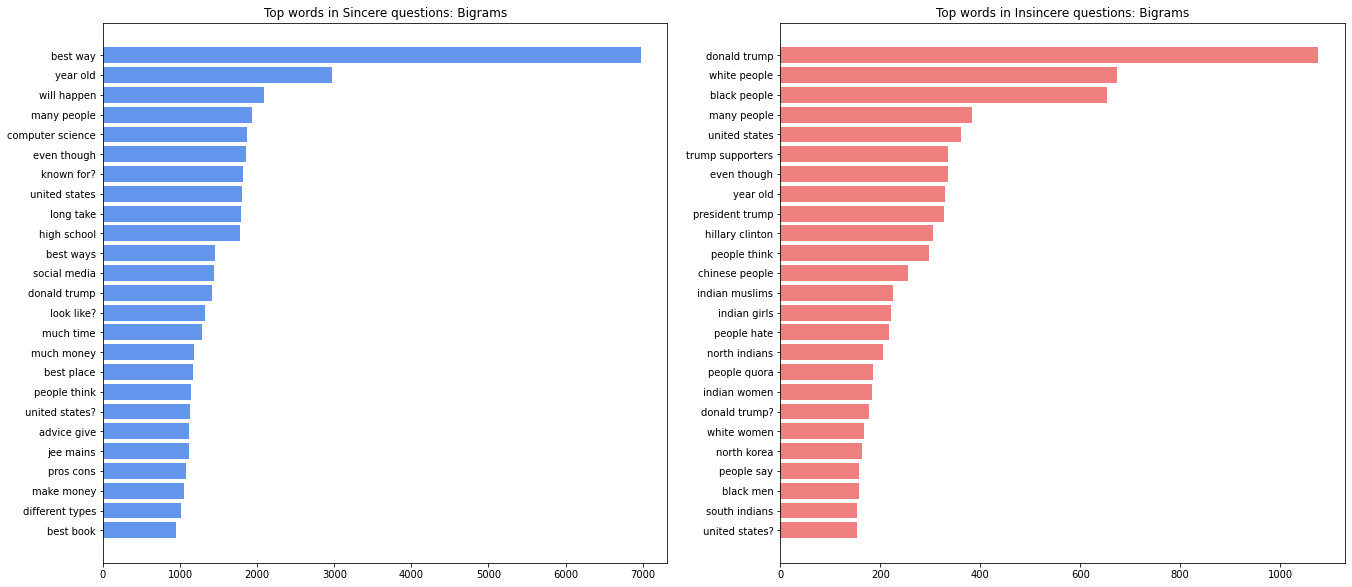

In [ ]:
pt.subplot(1, 2, 1)
plot_word_freq(bigrams_sincere, 'Sincere questions: Bigrams', 'cornflowerblue')

# Bigrams Insincere words
pt.subplot(1, 2, 2)
plot_word_freq(bigrams_insincere, 'Insincere questions: Bigrams', 'lightcoral')
pt.subplots_adjust(right=3.0)
pt.subplots_adjust(top=2.0)
pt.show()

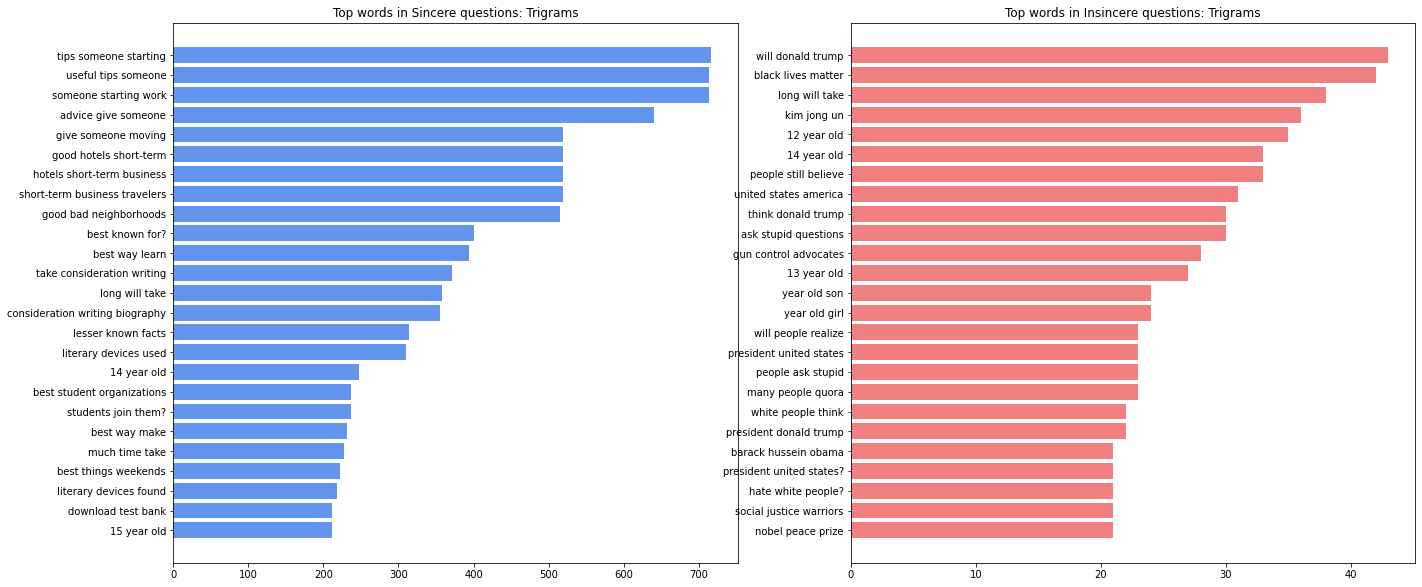

In [ ]:
# Trigrams Sincere words
pt.subplot(1, 2, 1)
plot_word_freq(trigrams_sincere, 'Sincere questions: Trigrams', 'cornflowerblue')

# Trigrams Insincere words
pt.subplot(1, 2, 2)
plot_word_freq(trigrams_insincere, 'Insincere questions: Trigrams', 'lightcoral')
pt.subplots_adjust(right=3.0)
pt.subplots_adjust(top=2.0)
pt.show()

In [ ]:
sincere=(df['target']==0)
insincere=(df['target']==1)

In [ ]:
df_sincere=df[sincere]
df_insincere=df[insincere]

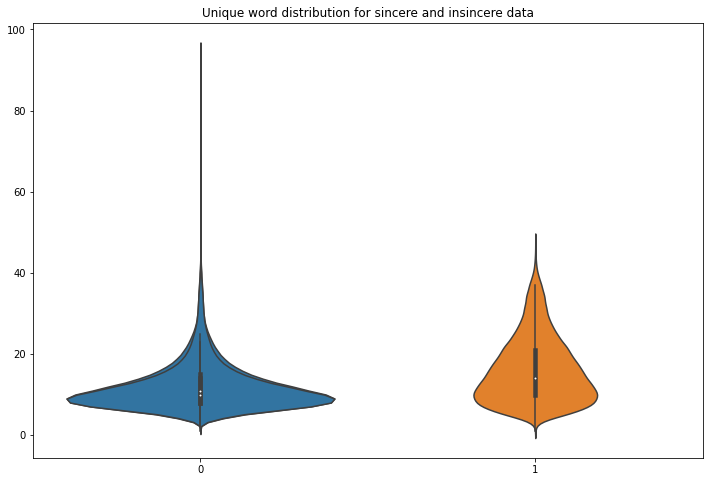

In [ ]:
## Number of unique words in the text ##
pt.figure(figsize=(12,8))
sns.violinplot(data=df['num_unique_word'])
sns.violinplot(data=[df_sincere['num_unique_word'],df_insincere['num_unique_word']])
pt.title("Unique word distribution for sincere and insincere data")
pt.show()

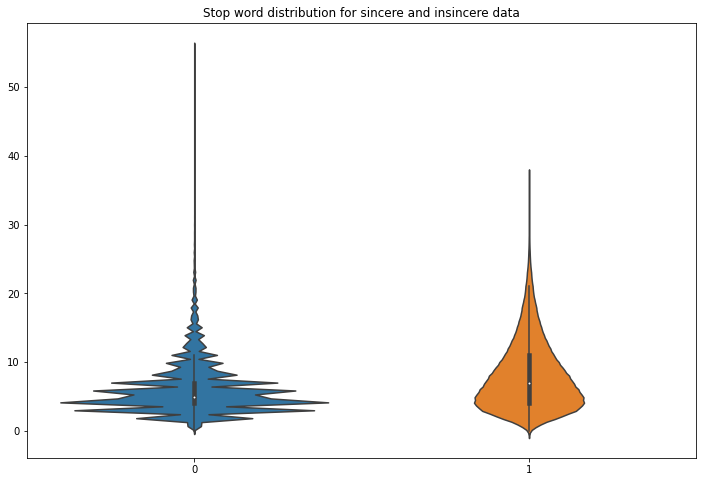

In [ ]:
## Number of stopwords in the text ##
pt.figure(figsize=(12,8))
sns.violinplot(data=[df_sincere['num_stopword'],df_insincere['num_stopword']])
pt.title("Stop word distribution for sincere and insincere data")
pt.show()

In [ ]:
df_sincere.head()

,qid,question_text,target,question_length,num_word,num_unique_word,num_char,num_stopword,num_word_upper,num_word_title,mean_word_len,num_special_char
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,13,13,13,72,7,0,2,4.615385,1
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,16,16,15,81,9,0,1,4.125000,2
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,10,10,8,67,3,0,2,5.800000,2
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,9,9,9,57,3,0,4,5.444444,1
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,15,15,15,77,8,2,3,4.200000,1


In [ ]:
df_sincere.shape

(1225312, 12)

In [ ]:
df_insincere.head()

,qid,question_text,target,question_length,num_word,num_unique_word,num_char,num_stopword,num_word_upper,num_word_title,mean_word_len,num_special_char
22,0000e91571b60c2fb487,Has the United States become the largest dicta...,1,11,11,9,67,5,0,3,5.181818,1
30,00013ceca3f624b09f42,Which babies are more sweeter to their parents...,1,15,15,13,86,6,0,2,4.800000,2
110,0004a7fcb2bf73076489,If blacks support school choice and mandatory ...,1,15,15,15,102,6,0,2,5.866667,2
114,00052793eaa287aff1e1,I am gay boy and I love my cousin (boy). He is...,1,34,34,26,137,20,5,8,3.058824,10
115,000537213b01fd77b58a,Which races have the smallest penis?,1,6,6,6,36,3,0,1,5.166667,1


In [ ]:
df_insincere.shape

(80810, 12)

In [ ]:
df_sample_insincere = df_insincere.iloc[:80000].copy() 
df_sample_sincere = df_sincere.iloc[:80000].copy() 

In [ ]:
frames = [df_sample_insincere, df_sample_sincere]
input = pd.concat(frames)

In [ ]:
input.shape

(160000, 12)

In [ ]:
input['question_text']

22       Has the United States become the largest dicta...
30       Which babies are more sweeter to their parents...
110      If blacks support school choice and mandatory ...
114      I am gay boy and I love my cousin (boy). He is...
115                   Which races have the smallest penis?
                               ...                        
85263    What are some of your favorite pictures of you...
85264         How transfer balance for Airtel to Vodafone?
85265    Men: How long do you date women if they are lu...
85266                     How does cacti live in a desert?
85268    How do I stop feeling like I'm not worth the w...
Name: question_text, Length: 160000, dtype: object

##**DATA** **MODELLING**
**Machine Learning Problem Type**: A binary classification problem,where we predict if a given question text is sincere or not

In [ ]:
#input_df=input.sample(frac = 1)
#input_df=input_df.sample(frac = 1) 

##change it back to input_df
#Independent features
X=input.drop('target',axis=1)

##Dependent features
y=input['target']

In [ ]:
def main():
  list_=input['question_text'].tolist() 
  with concurrent.futures.ProcessPoolExecutor() as executor:
    results = executor.map(stemming_, list_)
    return list(results)

In [ ]:
def classification(X_train,y_train,X_test,y_test,classifier):
  classifier.fit(X_train, y_train)
  pred = classifier.predict(X_test)
  score = metrics.accuracy_score(y_test, pred)
  creport = classification_report(y_test, pred)
  print(creport)
  cmatrix = metrics.confusion_matrix(y_test, pred)
  print(plot_confusion_matrix(cmatrix, classes=['FAKE', 'REAL']))
  print("accuracy:   %0.3f" % score,"\n")

In [ ]:
import matplotlib.pyplot as pt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=pt.cm.Blues):
    """
    See full source and example:
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    pt.imshow(cm, interpolation='nearest', cmap=cmap)
    pt.title(title)
    pt.colorbar()
    tick_marks = np.arange(len(classes))
    pt.xticks(tick_marks, classes, rotation=45)
    pt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        pt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    pt.tight_layout()
    pt.ylabel('True label')
    pt.xlabel('Predicted label')
    pt.show()

In [ ]:
ps = PorterStemmer()
def stemming_(question):
  review = re.sub('[^a-zA-Z]', ' ', question)
  review = review.lower()
  review = review.split()
  review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
  review = ' '.join(review)
  return review

NameError: ignored

In [ ]:
X.head()

In [ ]:
y.head()

In [ ]:
if __name__ == '__main__':
  results = main()
  print(type(results[0]))
  tfidf_v = TfidfVectorizer(max_features=5000, ngram_range=(1, 3))
  X = tfidf_v.fit_transform(results).toarray()
  #persist the vectorizer
  dump(tfidf_v,'tfidf')
  flat_list=None
  #Independent features
  y=input['target']
  ## Divide the dataset into Train and Test
  print(X.shape)
  print(y.shape)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
  list_=None
  del X
  del y
  

In [ ]:
  ##Multinomial Naive Bayes Model
  classifier = MultinomialNB()
  print("NBClassifierModel")
  classification(X_train,y_train,X_test,y_test,classifier)
  dump(classifier,'NBClassifierModel')

In [ ]:
##Passive Aggressive Classifier
classifier = PassiveAggressiveClassifier()
print("PAClassifierModel")
classification(X_train,y_train,X_test,y_test,classifier)
dump(classifier,'PAClassifierModel')

In [ ]:
##SVC Model
classifier = SVC(kernel='linear', random_state=0)
print("SVCModel")
classification(X_train,y_train,X_test,y_test,classifier)
dump(classifier,'SVCModel')

In [ ]:
##Logistic Regression Model
classifier = linear_model.LogisticRegression()
print("LogRegressionModel")
classification(X_train,y_train,X_test,y_test,classifier)
dump(classifier,'LogRegressionModel')

In [ ]:
  from sklearn.tree import DecisionTreeClassifier
  classifier = DecisionTreeClassifier(random_state=0)
  print("DTClassifier")
  classification(X_train,y_train,X_test,y_test,classifier)
  dump(classifier,'DTClassifier')

In [ ]:
##RandomForest Classifier
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(random_state=0)#max_depth=2, 
print("RFClassifier")
classification(X_train,y_train,X_test,y_test,classifier)
dump(classifier,'RFClassifier')